In [1]:
from google.oauth2 import service_account
from google.cloud import bigquery
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Credentials to access data in BigQuery
# Private information has been excluded to privacy reasons
credentials = service_account.Credentials.from_service_account_info(
    {
  "type": "service_account",
  "project_id": "dhutchings",
  "private_key_id": "XXXXXXXXXXXXXXXXXXXXXX",
  "private_key": "XXXXXXXXXXXXXXXXXXXXXX",
  "client_email": "dhutchings####################",
  "client_id": "XXXXXXXXXXXXXXXXXXXXXXXXXX",
  "auth_uri": "https://accounts.google.com/o/oauth2/auth",
  "token_uri": "https://oauth2.googleapis.com/token",
  "auth_provider_x509_cert_url": "https://www.googleapis.com/oauth2/v1/certs",
  "client_x509_cert_url": "XXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
}
)

client = bigquery.Client('dhutchings', credentials = credentials)

In [6]:
# Query the metric total_conversions
metric_query = '''
SELECT date, SUM(conversions) as total_conversions
FROM `dhutchings.lockerdome.all_months`
GROUP BY date
'''
df_metric = client.query(metric_query).to_dataframe()

In [8]:
# Query entire dataframe
df_all = client.query("SELECT * FROM `dhutchings.lockerdome.all_months`").to_dataframe()

In [43]:
# Query the total impressions for each device each day
df_device = df_all.groupby(['date']).apply(lambda df: df.groupby('device')['impressions'].sum())

df_device.reset_index(inplace=True)
df_device.drop(columns=['date'], inplace=True)
df_device.head()

device,Desktop,Mobile,Other,Tablet
0,813542,1164115,15,297290
1,727545,1081544,6,288526
2,641909,934360,5,200105
3,583884,934371,5,216483
4,645810,1255756,10,253522


In [20]:
# Concatenate metric and device dataframe
reg_df = pd.concat([df_metric,df_device], axis=1)

reg_df.rename(columns = {"Desktop": "desktop_impressions", 
                         "Mobile": "mobile_impressions", 
                         "Other": "other_impressions",
                         "Tablet": "tablet_impressions"}, inplace=True)

In [27]:
# Add a month column
reg_df['date'] = pd.to_datetime(reg_df['date'])
reg_df['month'] = reg_df['date'].dt.month
reg_df['month'] = reg_df['month'].astype(str)

In [30]:
# Independent variable dataframe
X = reg_df[[c for c in reg_df.columns if c not in ['total_conversions', 'date']]]
X = pd.get_dummies(X, columns=['month']). # converts month column to a dummy variable

In [31]:
# Dependent variable series
y = reg_df['total_conversions']

In [32]:
# Create model
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

In [36]:
# Regression results
summary_results = model.summary()
summary_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      total_conversions   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     93.65
Date:                Thu, 21 Jan 2021   Prob (F-statistic):           2.55e-35
Time:                        17:49:34   Log-Likelihood:                -347.13
No. Observations:                  92   AIC:                             708.3
Df Residuals:                      85   BIC:                             725.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.9236      3.565      1.662      0.100      -1.165      13.012
desktop_impressions  5.585e-05   5.29e-06     10.553      0.000    4.53e-05    6.64e-05
mobile_impressions   1.586e-05   3.82e-06      4.151      0.000    8.26e-06    2.35e-05
other_impressions       0.1326      0.226      0.587      0.559      -0.317       0.582
tablet_impressions   2.412e-05   9.77e-06      2.469      0.016     4.7e-06    4.35e-05
month_1                 6.6024      3.046      2.168      0.033       0.547      12.658
month_11                0.0894      2.402      0.037      0.970      -4.687       4.866
month_12               -0.7682      1.848     -0.416      0.679      -4.443       2.907
==============================================================================
Omnibus:                        3.230   Durbin-Watson:                   1.045
Prob(Omnibus):                  0.199   Jarque-Bera (JB):                2.554
Skew:                           0.371   Prob(JB):                        0.279
Kurtosis:                       3.339   Cond. No.                     2.26e+22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.19e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [37]:
# Convert regression results table into dataframe
results_as_html = summary_results.tables[1].as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

In [38]:
results_df

,coef,std err,t,P>|t|,[0.025,0.975]
const,5.923600,3.565000,1.662,0.100,-1.165000,13.012000
desktop_impressions,0.000056,0.000005,10.553,0.000,0.000045,0.000066
mobile_impressions,0.000016,0.000004,4.151,0.000,0.000008,0.000023
other_impressions,0.132600,0.226000,0.587,0.559,-0.317000,0.582000
tablet_impressions,0.000024,0.000010,2.469,0.016,0.000005,0.000044
month_1,6.602400,3.046000,2.168,0.033,0.547000,12.658000
month_11,0.089400,2.402000,0.037,0.970,-4.687000,4.866000
month_12,-0.768200,1.848000,-0.416,0.679,-4.443000,2.907000


In [39]:
# Model predictions on data it trained on
preds = model.predict(X)

Text(0.5, 1.0, 'Actual vs Preds')

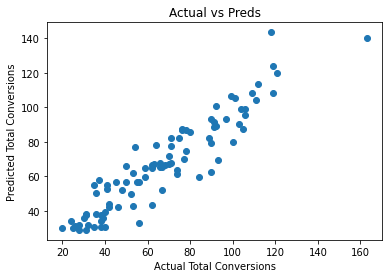

In [40]:
# Plot to visualize actuals vs preds
plt.scatter(y,preds)
plt.xlabel("Actual Total Conversions")
plt.ylabel("Predicted Total Conversions")
plt.title("Actual vs Preds")

In [41]:
# Mean absolute error of model
mean_absolute_error(y,preds)

8.000679588816842